# Recommender Systems

Recommender systems are useful for recommending users items based on their past preferences. Recommender systems are generally classified into the following categories:

- **Content-based** based on similarity of item attributes (information about items e.g. keywords, categories, etc. and users (preferences, profiles, etc.). For instance, if a user liked Item 1, the recommender system would recommend items with similar characteristics. If we would talk about movies, those characteristics would include producer, starring actors, genre, run time, release date, etc. Typically, this can be done with a binary classification supervised algorithm.


- **Collaborative filtering**, which calculates similarity from interactions (e.g. ratings, number of purchases, likes, etc.). This process finds customers who have similar preferences, and then gives recommendations to one customer from a set of items that are new to that particular customer and preferred by other customers with a similar profile. The system makes an assumption that users with similar movie watching habits have similar preferences in general. It finds users who watch videos similar to those the user watches, then identifies videos those similar users have watched, but which the first user has not. Finally, it makes recommendations on that basis. There are 3 approaches to this; user-user collaborative filtering, item-item collaborative filtering and matrix factorization.


- New approaches and usually more powerful are **Hybrid systems**, which combine the two aforementioned methods.

<img src="data/image.png">

The above diagram categorises in detail the different methodologies for building a recommender system.

In context to the `movieLens` that will be used later as a sample dataset:
- We will suggest different movies based on the content similarity, e.g. genre, cast, etc. applying an item-content filtering
- We could also compare the user metadata, such as age and gender, and suggest items to the user that similar users have liked. In that case, we would use a user-content filtering. The `movielens` dataset doesn't contain any user content data, so we will build only an item-item collaborative filtering.

**Memory-based** content filtering

In memory-based methods there is no model that learns from the data to predict. A pre-computed matrix of similarities is constructed that can be used for movie predic

__Load the datasets in three different pandas dataframes__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load movies data
movies = pd.read_csv('data/movies.csv')
tags = pd.read_csv('data/tags.csv')
ratings = pd.read_csv('data/ratings.csv')

display(movies.tail())
display(tags.head())
display(ratings.head())


,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


__remove the '|' that separates the different genres of movies and replace with an empty space__

In [2]:
movies['genres'] = movies['genres'].str.replace('|', ' ')

__Filter data to have only movies that have been rated__

In [3]:
movies = movies[movies.movieId.isin(ratings.movieId.unique())]
movies.shape

(9724, 3)

# Feature engineering

We're gonna create a new feature called `metadata`, that gathers all the text data information we have about a movie : the genre and the tags

__Merge the movies and tags data frames__

In [4]:
# Merge
merged = pd.merge(movies, tags, on='movieId', how='left')
# Drop useless columns.
merged.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar,1.139046e+09
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar,1.137207e+09
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun,1.525286e+09
3,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy,1.528844e+09
4,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game,1.528844e+09


__Create a new dataframe `df` of unique movies with [`moveId`, `title`, `genres`, `tag`, `metadata`] as columns__

Where `metadata` column contains the contatenated string of all `tags` and `genres` related to this movie.   
For instance, for Toy Story, the metadata = 'pixar pixar fun Adventure Animation Children Comedy Fantasy'

In [5]:
merged=merged.fillna("")
merged=pd.DataFrame(merged.groupby("movieId")['tag'].apply(lambda x: " ".join(x)))
merged_df=pd.merge(movies, merged, on="movieId", how="left")
merged_df['metadata']=merged_df[['tag', 'genres']].apply(lambda x: " ".join(x),axis=1)

In [13]:
from joblib import dump, load
name_lst.dump("data/name_lst.joblib")

In [15]:
load("data/name_lst.joblib")

array(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       ..., 'Flint (2017)', 'Bungo Stray Dogs: Dead Apple (2018)',
       'Andrew Dice Clay: Dice Rules (1991)'], dtype=object)

## Create a content latent matrix from metadata

### Tf-idf

Next we need to transform the metadata text to vectors, in order to feed it to our machine learning algorithms. Machine Learning models don't understand text data so we need to encode it.

We're gonna use the `TfidfVectorizer` to encode the metadata column. 

Create this new dataframe with the vectors you get from this tf idf transformation. Every line is now the tf-idf vector for this specific movie.

In [56]:
# Take time to understand how Tfidf workds below
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(merged_df['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=merged_df.index.tolist())
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
tfidf_df.shape

(9724, 1675)

### Dimensionality reduction

Each movie metadata was transformed into a vector of length 1677! (approximately)

We can apply dimensionality reduction methods to describe the data (movies) without much loss of information. Truncated singular value decomposition (SVD) is another advanced tool to reduce dimensions.

Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently. In particular, truncated SVD works on term count/tf-idf matrices. In that context, it is known as latent semantic analysis (LSA).

You can look at `TruncatedSVD` class in scikit learn but it's the same principle as PCA

__apply the truncated SVD to a number of components (say 25) to reduce the dimension of your tf idf matrix__

In [58]:
# apply TruncatedSVD
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)
latent_df = svd.fit_transform(tfidf_df)

In [9]:
# Plot variance as a function of the number of components.
def plot_var(svd):
    plt.plot(svd.explained_variance_ratio_.cumsum())
    plt.xlabel("number of singular value components")
    plt.ylabel("Cumalative percent of variance")
    plt.grid()
    plt.show()

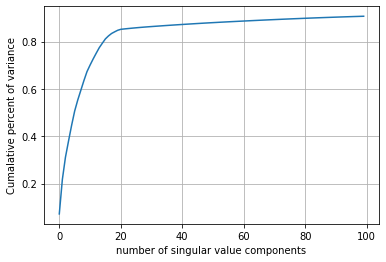

In [10]:
plot_var(svd)

We can see that with only the first 25 components (from initially about 1700) we can explain more than 80% of the variance, which suffices for our study purposes.

In [60]:
# keep the first 25 number of latent components.
n=25
latent_df = pd.DataFrame(latent_df[:,:n], index=merged_df.title.tolist())

In [66]:
dump(latent_df, "data/metadata_latent_matrix.joblib")

['data/metadata_latent_matrix.joblib']

In [ ]:
load("data/metadata_latent_matrix.joblib").index.str.contains(",")

## Create a latent matrix from user ratings

Beyond metadata, the user ratings is another valuable source of information: A recommender system can recommend a movie that is similar on the basis of user ratings (item-item collaborative filtering).

Create a (9724, 610) pivot dataframe containing all user `ratings`, with `movieId` as index, and all `userId` as columns. Replace rating by `0` when missing

In [12]:
ratings2=ratings.pivot(index = "movieId", columns="userId", values="rating").fillna(0)
ratings2.shape

(9724, 610)

Now, we created a dataset with movies as vectors of length 9724.

Once again, we will apply SVD so as to keep only the first 200 principal components (out of 610)

In [13]:
svd_rating = TruncatedSVD(n_components=200)
latent_df_rating = svd_rating.fit_transform(ratings2)
latent_df_rating=pd.DataFrame(latent_df_rating, index=merged_df.title.tolist())

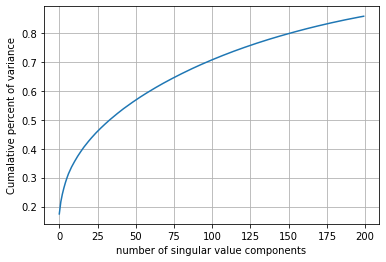

In [14]:
plot_var(svd_rating)

## Apply cosine similarity in content and colaborative matrices

Next, we will use a similarity measure so as to find the top $N$ most similar movies to "Toy Story" based on the filtering methods we created. Cosine similarity is one of the similarity measures we can use (`sklearn.metrics.pairwise.cosine_similarity`)

__Calculate the cosine similarity of a sample movie ("Toy Story") to both content and collaborative latent matrices.__

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

example = "Toy Story (1995)"

# Get the latent vectors for "Toy Story" from content and collaborative matrics
v1=np.array(latent_df.loc[example]).reshape(1,-1)
v2=np.array(latent_df_rating.loc[example]).reshape(1,-1)

# Compute the cosine similarity of this movie with the others 
sim1 = cosine_similarity(latent_df, v1).reshape(-1)
sim2 = cosine_similarity(latent_df_rating, v2).reshape(-1)


We can also create a hybrid filter, which is an average measure of similarity from both content and collaborative filtering. 

`hybrid-similarity = (content-similarity + collab-similarity) / 2`

__Calculate the average measure of both content and collaborative__

In [16]:
hybrid = ((sim1 + sim2)/2.0)

__Create a dataframe with the final similarities to Toy Story__

In [17]:
recommendation_df=pd.DataFrame({"content": sim1,
              "rating": sim2,
              "hybrid": hybrid}, index= merged_df.title.tolist())

In [24]:
recommendation_df[~recommendation_df.index.isin(["Grumpier Old Men (1995)", "Toy Story (1995)", "Jumanji (1995)"])].sort_values(by="content")

,content,rating,hybrid
"Sound of Music, The (1965)",-0.002969,0.379743,0.188387
Oklahoma! (1955),-0.002342,0.105970,0.051814
Rocky (1976),-0.002330,0.384492,0.191081
Gigi (1958),-0.002138,0.083719,0.040791
Yentl (1983),-0.002105,0.071191,0.034543
...,...,...,...
"Adventures of Rocky and Bullwinkle, The (2000)",0.999931,0.159778,0.579854
Shrek the Third (2007),0.999931,0.201849,0.600890
Asterix and the Vikings (Astérix et les Vikings) (2006),0.999931,0.052626,0.526278
The Good Dinosaur (2015),0.999931,0.126095,0.563013


__Sort your dataframe by most similar in terms of collaborative similarity__

You should see Toy Story as the most similar movie of course (similarity of 1 for every column)

__You can sort on contant as well as hybrid and see which one gives the best recommentation__

In [112]:
recommendation_df.sort_values("rating", ascending=False, inplace=True)

In [114]:
recommendation_df.head(10)

,content,rating,hybrid
Toy Story (1995),1.000000,1.000000,1.000000
Toy Story 2 (1999),0.942748,0.646324,0.794536
Independence Day (a.k.a. ID4) (1996),0.187164,0.628070,0.407617
Jurassic Park (1993),0.188764,0.615535,0.402150
Mission: Impossible (1996),0.204963,0.608802,0.406883
Star Wars: Episode IV - A New Hope (1977),0.106643,0.596161,0.351402
"Lion King, The (1994)",0.545433,0.586842,0.566137
Star Wars: Episode VI - Return of the Jedi (1983),0.202920,0.582859,0.392890
Shrek (2001),0.933199,0.580774,0.756987
Forrest Gump (1994),0.091744,0.576434,0.334089


In [115]:
recommendation_df.sort_values('content', ascending=False, inplace=True)
recommendation_df.head(10)

,content,rating,hybrid
Toy Story (1995),1.000000,1.000000,1.000000
"Wild, The (2006)",0.999935,0.076852,0.538394
Antz (1998),0.999935,0.397691,0.698813
The Good Dinosaur (2015),0.999935,0.123215,0.561575
Asterix and the Vikings (Astérix et les Vikings) (2006),0.999935,0.051764,0.525849
"Emperor's New Groove, The (2000)",0.999935,0.300429,0.650182
Moana (2016),0.999935,0.060148,0.530042
Turbo (2013),0.999935,0.089785,0.544860
Shrek the Third (2007),0.999935,0.210530,0.605232
"Tale of Despereaux, The (2008)",0.999935,0.070996,0.535466
